[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1_76P6hvYY5tHdD8pPswMeNP_VrhAnh5y?usp=sharing)     

# Chapter 11 - Red-Teaming an XGBoost Credit Model

## Training an XGBoost Model

## Setting the environment

Download the [zipped **data_and_package** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/data_and_package.zip) onto your local system and save it as `Data.zip`. 

In [1]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

Saving data_and_package.zip to data_and_package.zip


In [ ]:
!unzip -q "/content/Data.zip"
%cd /content/Data

## 1. Creating an overfit XGBoost model using H2O-3

In [3]:
# Installing the latest version of H2O
%pip install h2o 

     |████████████████████████████████| 177.2 MB 44 kB/s 


Global hyperpameters

In [4]:
SEED = 12345 # global random seed for better reproducibility

Python imports and inits

In [5]:
import h2o
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

import matplotlib.pyplot as plt # general plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# display plots in-notebook
%matplotlib inline   

h2o.init(max_mem_size='4G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators  

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqgtqqlkw
  JVM stdout: /tmp/tmpqgtqqlkw/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpqgtqqlkw/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_unknownUser_mte6ki
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Importing dataset 

In [6]:
data = pd.read_csv('Data/credit_line_increase.csv')
data.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
0,1,20000,2,1.0,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,3.0,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,4.0,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,3.0,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
data.describe()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,2.721967,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,1.094397,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,2.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,3.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,4.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


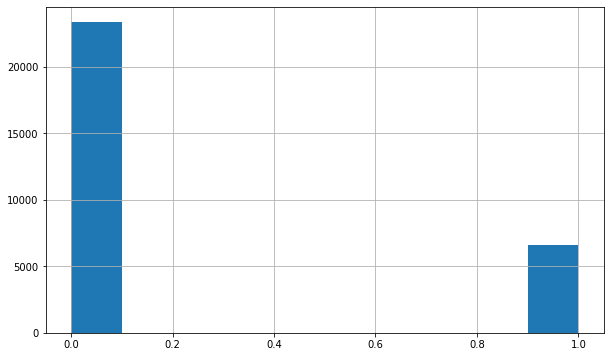

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
data['DELINQ_NEXT'].hist()


### Splitting dataset into train, validation and test set


In [9]:
id_col = 'ID'
groups = ['SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']
target = 'DELINQ_NEXT'

In [10]:
np.random.seed(SEED)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19919/5045/5036


### Assign target and inputs for models
Note that Demographic features are not used as model inputs.

In [11]:
target = 'DELINQ_NEXT'
demographic_cols = ['SEX', 'RACE','EDUCATION', 'MARRIAGE', 'AGE']
features = [col for col in train.columns if col not in demographic_cols + ['ID',target]]

print('target =', target)
print('predictors =', features)

target = DELINQ_NEXT
predictors = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [12]:
# Converting Pandas dataframe into H2O Frame
training_frame = h2o.H2OFrame(train)
validation_frame = h2o.H2OFrame(valid)
test_frame = h2o.H2OFrame(test)

In [13]:
# Setting target column to factor so we can build classification model

training_frame[target] = training_frame[target].asfactor()
validation_frame[target] = validation_frame[target].asfactor()
test_frame[target] = test_frame[target].asfactor()

### Training an H2O XGBoost model

### Setting XGBooost Parameters



In [14]:
param = {
      "ntrees" : 100
    , "max_depth" : 10
    , "learn_rate" : 0.1
    , "sample_rate" : 0.9
    , "col_sample_rate_per_tree" : 1
    , "min_rows" : 5
    , "seed": SEED
    , "score_tree_interval": 10
}

In [15]:
#Setting H2O XGBoost model configuration (default)
xgb_clf = H2OXGBoostEstimator(**param)

In [16]:
#Training H2O XGBoost model
xgb_clf = xgb_clf.train(x=features, y=target, 
                        training_frame=training_frame, validation_frame=validation_frame)

### Evaluating model performance of validation set

#### AUC

In [17]:
perf_train = xgb_clf.model_performance(train=True)
perf_valid = xgb_clf.model_performance(valid=True)


x = perf_train.plot(type = 'roc',plot=False);
y = perf_valid.plot(type = 'roc',plot=False);


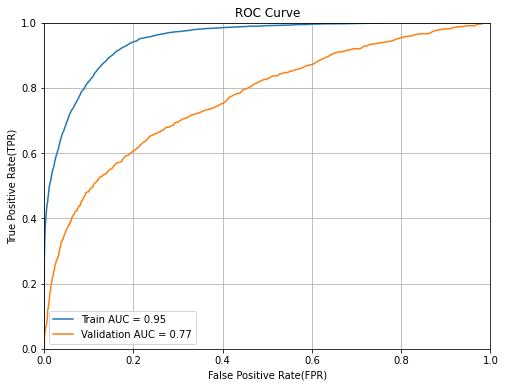

In [18]:
plt.figure(figsize=(8,6))
plt.plot(x[0],x[1],label=f'Train AUC = {np.round(xgb_clf.model_performance(train=True).auc(),2)}')
plt.plot(y[0],y[1],label=f'Validation AUC = {np.round(xgb_clf.model_performance(valid=True).auc(),2)}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.grid()



### Test Set performance

In [19]:
perf_test = xgb_clf.model_performance(test_data=test_frame)
perf_test.auc()

0.773368620783262

In [20]:
#Exporting XGBoost Model
# xgb_clf.download_mojo("../Models/overfit_model.zip", get_genmodel_jar=True)

## 2. Training a Regularised & Constrained XGBoost model using H2O-3

### Investigating Pairwise Spearman Correlations with the Target Variable

In [20]:
corr = pd.DataFrame(train[features + [target]].corr(method='spearman')[target]).iloc[:-1]
corr.columns = ['Spearman Correlation Coefficient']
corr

,Spearman Correlation Coefficient
LIMIT_BAL,-0.167321
PAY_0,0.288930
PAY_2,0.212779
PAY_3,0.191448
PAY_4,0.169851
PAY_5,0.155790
PAY_6,0.140604
BILL_AMT1,-0.026095
BILL_AMT2,-0.016209
BILL_AMT3,-0.015338


### Creating a dictionary of monotonicity constraints from Spearman's correlation values

In [21]:
values = [int(i) for i in np.sign(corr.values)]
mono_constraints = dict(zip(corr.index, values))
mono_constraints

{'LIMIT_BAL': -1,
 'PAY_0': 1,
 'PAY_2': 1,
 'PAY_3': 1,
 'PAY_4': 1,
 'PAY_5': 1,
 'PAY_6': 1,
 'BILL_AMT1': -1,
 'BILL_AMT2': -1,
 'BILL_AMT3': -1,
 'BILL_AMT4': -1,
 'BILL_AMT5': -1,
 'BILL_AMT6': -1,
 'PAY_AMT1': -1,
 'PAY_AMT2': -1,
 'PAY_AMT3': -1,
 'PAY_AMT4': -1,
 'PAY_AMT5': -1,
 'PAY_AMT6': -1}

### Train XGBoost with  L2 Regularisation

Using grid Search to find the best hyperparameter values

In [ ]:
#Settings XGB grid parameters
# hyper_parameters = {'reg_lambda': [0.01, 0.25, 0.5, 0.99],
#                         'min_child_weight': [1, 5, 10],
#                         'eta': [0.01, 0.05],
#                         'subsample': [0.6, 0.8, 1.0],
#                         'colsample_bytree': [0.6, 0.8, 1.0],
#                         'max_depth': [5, 10, 15]}
                                        


# # initialize cartesian grid search
# xgb_grid = H2OGridSearch(model = H2OXGBoostEstimator,
#                                       hyper_params=hyper_parameters,
#                                       parallelism = 3)

# # training w/ grid search
# xgb_grid.train(x=features, 
#                y=target,
#                training_frame=training_frame,
#                validation_frame=validation_frame,
#                seed=SEED)


In [22]:
# params obtained out of grid Search
params_best = {'reg_lambda': 0.25,
               'min_child_weight': 1,
               'eta': 0.08,
               # 'learn_rate': 0.08,
               'sample_rate': 0.8,
               'col_sample_rate_per_tree': 0.8,
               'max_depth': 3}


In [23]:
# Applying monotonic constraints
xgb_best = H2OXGBoostEstimator(**params_best, 
                               monotone_constraints=mono_constraints)

In [24]:
xgb_best.train(x = features, y = target, training_frame = training_frame, validation_frame = validation_frame)

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Using user-provided parameter eta instead of learn_rate."
  warnings.warn(mesg["message"], RuntimeWarning)


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1665633101583_25


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13461924581252632
RMSE: 0.3669049547396796
LogLoss: 0.4304101635202294
Mean Per-Class Error: 0.28796974228682637
AUC: 0.7779753516755709
AUCPR: 0.5533169537889702
Gini: 0.5559507033511417

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22825836261798596
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      12773  2758  0.1776   (2758.0/15531.0)
1      1748   2640  0.3984   (1748.0/4388.0)
Total  14521  5398  0.2262   (4506.0/19919.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.228258     0.539546  238
max f2                       0.134865     0.635712  322
max f0point5                 0.427023     0.583517  146
max accuracy                 0.460925     0.822682  135
max precision                0.886433     1         0
max recall                   0.059371     1         394
max specificity              0.886433     1         0
max absolute_mcc             0.367285     0.416834  170
max min_per_class_accuracy   0.186337     0.704649  271
max mean_per_class_accuracy  0.225281     0.712668  240
max tns                      0.886433     15531     0
max fns                      0.886433     4379      0
max fps                      0.0485393    15531     399
max tps                      0.059371     4388      394
max tnr                      0.886433     1         0
max fnr                      0.886433     0.997949  0
max fpr                      0.0485393    1         399
max tpr                      0.059371     1         394

Gains/Lift Table: Avg response rate: 22.03 %, avg score: 22.36 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100407                   0.790405           3.67693   3.67693            0.81             0.83249    0.81                        0.83249             0.0369189       0.0369189                  267.693   267.693            0.0344722
2        0.0213364                   0.781702           3.55084   3.61018            0.782222         0.784178   0.795294                    0.806913            0.0401094       0.0770283                  255.084   261.018            0.0714266
3        0.0300216                   0.754199           3.41113   3.55259            0.751445         0.771448   0.782609                    0.796653            0.0296263       0.106655                   241.113   255.259            0.0982842
4        0.040012                    0.707961           3.37606   3.50851            0.743719         0.72792    0.772898                    0.779491            0.0337284       0.140383                   237.606   250.851            0.128729
5        0.0500025                   0.674446           3.23919   3.4547             0.713568         0.690928   0.761044                    0.761796            0.032361        0.172744                   223.919   245.47             0.15742
6        0.100156                    0.557517           2.88996   3.17191            0.636637         0.613811   0.698747                    0.687693            0.144941        0.317685                   188.996   217.191            0.278988
7        0.150008                    0.361426           2.25371   2.86677    

### Evaluating model performance of validation set



In [25]:
perf_train = xgb_best.model_performance(train=True)
perf_valid = xgb_best.model_performance(valid=True)

x = perf_train.plot(type = 'roc',plot=False);
y = perf_valid.plot(type = 'roc',plot=False);

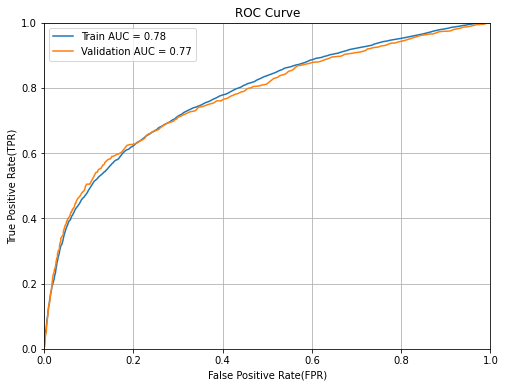

In [26]:
plt.figure(figsize=(8,6))
plt.plot(x[0],x[1],label=f'Train AUC = {np.round(xgb_best.model_performance(train=True).auc(),2)}')
plt.plot(y[0],y[1],label=f'Validation AUC = {np.round(xgb_best.model_performance(valid=True).auc(),2)}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.grid()

In [27]:
perf_test2 = xgb_best.model_performance(test_data=test_frame)
perf_test2.auc()

0.7751945519213587

In [ ]:
#Exporting the best XGBoost Model
xgb_best.download_mojo("../Models/constrained_model.zip", get_genmodel_jar=True)

## Shutdown H2O CLuster

In [ ]:
h2o.cluster().shutdown(prompt=True)